## Mars Photogrammetry Preprocessing Pipeline

By Christian Tate, Cornell University; Ithaca, NY

https://github.com/cdt59/MPPP


In [1]:
# Import python modules

import numpy as np
import cv2, glob, time, os
import matplotlib.pyplot as plt

# from planetaryimage import PDS3Image
# import colour_demosaicing
# from PIL import Image
# import matplotlib.cm as cm
# from scipy import interpolate
# from scipy.spatial.transform import Rotation as R
# import colour_demosaicing
import pandas as pd

%run MPPP.py

%matplotlib inline

# time.sleep(20*60)

In [11]:
# Set input path to IMG files and search criteria

pre = ''
suf = 'references'


# Set input and output directories
directory_input  = 'Z:/Mastcam-Z/agisoft/data'
directory_output = 'Z:/Mastcam-Z/agisoft/images'

directory_input  = 'C:/Users/cdt59/Desktop/heli/data'
directory_output = 'C:/Users/cdt59/Desktop/heli'

# directory_input  = 'C:/Users/cdt59/Desktop/agisoft/data'
# directory_output = 'C:/Users/cdt59/Desktop/agisoft/images'

# directory_input  = 'C:/Users/cdt59/Downloads/Mars_2020_sol_681/data'
# directory_output = directory_input
# sol = 6

sol = '17'

pre = 'Z*0_0'+str(sol)+'*_07'
suf = 'refs_'+str(sol).zfill(3)+'_zcam'

# pre = '*F_0'+str(sol)+'*_07'
# suf = 'refs_'+str(sol).zfill(3)+'_ecam'

# pre = '*M_0'+str(sol)+'*_07'
# suf = 'refs_'+str(sol).zfill(3)+'_vce_ecam'

# pre = '*V0'+str(sol)+'*_07'
# suf = 'refs_'+str(sol).zfill(3)+'_vec'

pre = 'H*_0'+str(sol)+'*_06'
suf = 'refs_'+str(sol).zfill(3)+'_heli'


sequ_id = ''

path_input     = directory_input
IMG_paths      = [] 
IMG_paths     += sorted( glob.glob(  directory_input + '/' +pre+'*_N*'+sequ_id+'*.IMG' ) ) 
IMG_paths     += sorted( glob.glob(  directory_input + '/*/ids/rdr/*/' +pre+'*_N*'+sequ_id+'*.IMG' ) ) 

if 'F_0' in pre or 'V' in pre or 'M' in pre: 
    IMG_paths += sorted( glob.glob(  directory_input + '/datadrive/*/ids/rdr/*/' +pre+'*_N*'+sequ_id+'*.IMG' ) ) 
    IMG_paths += sorted( glob.glob(  directory_input + '/datadrive/' +pre+'*_N*'+sequ_id+'*.IMG' ) ) 
if 'Z' in pre: 
    IMG_paths += sorted( glob.glob(  directory_input + '/zcam/' +pre+'*_N*'+sequ_id+'*.IMG' ) ) 
    IMG_paths += sorted( glob.glob(  directory_input + '/zcam/*/' +pre+'*_N*'+sequ_id+'*.IMG' ) ) 


IMG_paths = IMG_paths[:]



print( len(IMG_paths), 'images\n')

# IMG_paths = [ 'Z:/Mastcam-Z/agisoft/data/zcam\\sol_0600s\\ZL0_0690_0728196929_035RAD_N0321184ZCAM08692_0340LMA01.IMG','Z:/Mastcam-Z/agisoft/data/zcam\\sol_0600s\\ZL0_0690_0728198458_034RAD_N0321184ZCAM08692_0340LMA01.IMG' ]

# # remove duplicates in image set

# %run MPPP.py
# remove_duplicate_IMGs( IMG_paths )

IMG_paths

322 images



['C:/Users/cdt59/Desktop/heli/data\\HNM_0174_0682390500_075RAD_N0120001HELI00488_0000LUJ01.IMG',
 'C:/Users/cdt59/Desktop/heli/data\\HNM_0174_0682390500_960RAD_N0120001HELI00515_0000LUJ01.IMG',
 'C:/Users/cdt59/Desktop/heli/data\\HNM_0174_0682390501_857RAD_N0120001HELI00542_0000LUJ01.IMG',
 'C:/Users/cdt59/Desktop/heli/data\\HNM_0174_0682390502_752RAD_N0120001HELI00569_0000LUJ01.IMG',
 'C:/Users/cdt59/Desktop/heli/data\\HNM_0174_0682390503_649RAD_N0120001HELI00596_0000LUJ01.IMG',
 'C:/Users/cdt59/Desktop/heli/data\\HNM_0174_0682390504_543RAD_N0120001HELI00623_0000LUJ01.IMG',
 'C:/Users/cdt59/Desktop/heli/data\\HNM_0174_0682390505_440RAD_N0120001HELI00650_0000LUJ01.IMG',
 'C:/Users/cdt59/Desktop/heli/data\\HNM_0174_0682390506_334RAD_N0120001HELI00677_0000LUJ01.IMG',
 'C:/Users/cdt59/Desktop/heli/data\\HNM_0174_0682390507_233RAD_N0120001HELI00704_0000LUJ01.IMG',
 'C:/Users/cdt59/Desktop/heli/data\\HNM_0174_0682390508_126RAD_N0120001HELI00731_0000LUJ01.IMG',
 'C:/Users/cdt59/Desktop/heli/

312 images

0 HNM_0174_0682390500_075RAD_N0120001HELI00488_0000LUJ01.IMG
sol 174 site 12 drive 488  zenith angle -5266 scale 1.00
XYZ_ENU = [-680.66, -709.20, 0.01] YPR = [140, -2, -4]  OPK = [-1, 4, -140]

1 HNM_0174_0682390500_960RAD_N0120001HELI00515_0000LUJ01.IMG
sol 174 site 12 drive 515  zenith angle -5209 scale 1.00
XYZ_ENU = [-680.64, -709.20, 0.46] YPR = [140, -1, -4]  OPK = [-2, 3, -140]

2 HNM_0174_0682390501_857RAD_N0120001HELI00542_0000LUJ01.IMG
sol 174 site 12 drive 542  zenith angle -5256 scale 1.00
XYZ_ENU = [-680.68, -709.22, 1.16] YPR = [140, -2, -4]  OPK = [-1, 4, -140]

3 HNM_0174_0682390502_752RAD_N0120001HELI00569_0000LUJ01.IMG
sol 174 site 12 drive 569  zenith angle -5246 scale 1.00
XYZ_ENU = [-680.72, -709.22, 2.05] YPR = [141, -2, -5]  OPK = [-2, 5, -141]

4 HNM_0174_0682390503_649RAD_N0120001HELI00596_0000LUJ01.IMG
sol 174 site 12 drive 596  zenith angle -5243 scale 1.00
XYZ_ENU = [-680.71, -709.20, 2.97] YPR = [141, -1, -4]  OPK = [-2, 4, -141]

5 HNM_0174_06

sol 174 site 12 drive 1622  zenith angle -5222 scale 1.00
XYZ_ENU = [-603.76, -686.43, 10.14] YPR = [163, -1, -4]  OPK = [-0, 4, -163]

43 HNM_0174_0682390538_578RAD_N0120001HELI01649_0000LUJ01.IMG
sol 174 site 12 drive 1649  zenith angle -4963 scale 1.00
XYZ_ENU = [-600.38, -685.17, 10.18] YPR = [164, 3, 2]  OPK = [-3, -3, -164]

44 HNM_0174_0682390539_476RAD_N0120001HELI01676_0000LUJ01.IMG
sol 174 site 12 drive 1676  zenith angle -5180 scale 1.00
XYZ_ENU = [-597.12, -684.44, 10.77] YPR = [164, -0, 6]  OPK = [2, -6, -164]

45 HNM_0174_0682390540_370RAD_N0120001HELI01703_0000LUJ01.IMG
sol 174 site 12 drive 1703  zenith angle -4851 scale 1.00
XYZ_ENU = [-594.34, -683.81, 10.86] YPR = [164, 5, 9]  OPK = [-3, -10, -164]

46 HNM_0174_0682390541_267RAD_N0120001HELI01730_0000LUJ01.IMG
sol 174 site 12 drive 1730  zenith angle -4961 scale 1.00
XYZ_ENU = [-592.21, -683.19, 10.67] YPR = [163, 3, 9]  OPK = [-1, -10, -162]

47 HNM_0174_0682390542_164RAD_N0120001HELI01757_0000LUJ01.IMG
sol 174 site

84 HNM_0174_0682390575_302RAD_N0120001HELI02756_0000LUJ01.IMG
sol 174 site 12 drive 2756  zenith angle -5166 scale 1.00
XYZ_ENU = [-680.65, -709.20, -0.09] YPR = [141, -0, -3]  OPK = [-2, 3, -141]

85 HNM_0174_0682390576_197RAD_N0120001HELI02783_0000LUJ01.IMG
sol 174 site 12 drive 2783  zenith angle -5166 scale 1.00
XYZ_ENU = [-680.65, -709.20, -0.09] YPR = [141, -0, -3]  OPK = [-2, 3, -141]

86 HNM_0174_0682390577_094RAD_N0120001HELI02810_0000LUJ01.IMG
sol 174 site 12 drive 2810  zenith angle -5166 scale 1.00
XYZ_ENU = [-680.65, -709.20, -0.09] YPR = [141, -0, -3]  OPK = [-2, 3, -141]

87 HNM_0174_0682390577_990RAD_N0120001HELI02837_0000LUJ01.IMG
sol 174 site 12 drive 2837  zenith angle -5166 scale 1.00
XYZ_ENU = [-680.65, -709.20, -0.09] YPR = [141, -0, -3]  OPK = [-2, 3, -141]

88 HNM_0174_0682390578_888RAD_N0120001HELI02864_0000LUJ01.IMG
sol 174 site 12 drive 2864  zenith angle -5166 scale 1.00
XYZ_ENU = [-680.65, -709.20, -0.09] YPR = [141, -0, -3]  OPK = [-2, 3, -141]

89 HNM_017

126 HNM_0174_0682390612_921RAD_N0120001HELI03890_0000LUJ01.IMG
sol 174 site 12 drive 3890  zenith angle -5166 scale 1.00
XYZ_ENU = [-680.65, -709.20, -0.09] YPR = [141, -0, -3]  OPK = [-2, 3, -141]

127 HNM_0174_0682390613_817RAD_N0120001HELI03917_0000LUJ01.IMG
sol 174 site 12 drive 3917  zenith angle -5166 scale 1.00
XYZ_ENU = [-680.65, -709.20, -0.09] YPR = [141, -0, -3]  OPK = [-2, 3, -141]

128 HNM_0174_0682390614_712RAD_N0120001HELI03944_0000LUJ01.IMG
sol 174 site 12 drive 3944  zenith angle -5166 scale 1.00
XYZ_ENU = [-680.65, -709.20, -0.09] YPR = [141, -0, -3]  OPK = [-2, 3, -141]

129 HNM_0174_0682390615_606RAD_N0120001HELI03971_0000LUJ01.IMG
sol 174 site 12 drive 3971  zenith angle -5166 scale 1.00
XYZ_ENU = [-680.65, -709.20, -0.09] YPR = [141, -0, -3]  OPK = [-2, 3, -141]

130 HNM_0174_0682390616_503RAD_N0120001HELI03998_0000LUJ01.IMG
sol 174 site 12 drive 3998  zenith angle -5166 scale 1.00
XYZ_ENU = [-680.65, -709.20, -0.09] YPR = [141, -0, -3]  OPK = [-2, 3, -141]

131 H

168 HNM_0174_0682390650_543RAD_N0120001HELI05024_0000LUJ01.IMG
sol 174 site 12 drive 5024  zenith angle -5166 scale 1.00
XYZ_ENU = [-680.65, -709.20, -0.09] YPR = [141, -0, -3]  OPK = [-2, 3, -141]

169 HNM_0174_0682390651_435RAD_N0120001HELI05051_0000LUJ01.IMG
sol 174 site 12 drive 5051  zenith angle -5166 scale 1.00
XYZ_ENU = [-680.65, -709.20, -0.09] YPR = [141, -0, -3]  OPK = [-2, 3, -141]

170 HNM_0174_0682390652_336RAD_N0120001HELI05078_0000LUJ01.IMG
sol 174 site 12 drive 5078  zenith angle -5166 scale 1.00
XYZ_ENU = [-680.65, -709.20, -0.09] YPR = [141, -0, -3]  OPK = [-2, 3, -141]

171 HNM_0174_0682390653_224RAD_N0120001HELI05105_0000LUJ01.IMG
sol 174 site 12 drive 5105  zenith angle -5166 scale 1.00
XYZ_ENU = [-680.65, -709.20, -0.09] YPR = [141, -0, -3]  OPK = [-2, 3, -141]

172 HNM_0174_0682390654_121RAD_N0120001HELI05132_0000LUJ01.IMG
sol 174 site 12 drive 5132  zenith angle -5166 scale 1.00
XYZ_ENU = [-680.65, -709.20, -0.09] YPR = [141, -0, -3]  OPK = [-2, 3, -141]

173 H

210 HNM_0174_0682390585_153RAD_N0120001HELI03053_0000LUJ02.IMG
sol 174 site 12 drive 3053  zenith angle -5494 scale 1.00
XYZ_ENU = [-456.22, -642.32, 9.91] YPR = [162, -6, -6]  OPK = [4, 8, -162]

211 HNM_0174_0682390586_050RAD_N0120001HELI03080_0000LUJ02.IMG
sol 174 site 12 drive 3080  zenith angle -5328 scale 1.00
XYZ_ENU = [-456.08, -642.43, 9.88] YPR = [163, -3, -6]  OPK = [1, 7, -162]

212 HNM_0174_0682390586_948RAD_N0120001HELI03107_0000LUJ02.IMG
sol 174 site 12 drive 3107  zenith angle -4674 scale 1.00
XYZ_ENU = [-455.92, -642.61, 9.86] YPR = [163, 8, -6]  OPK = [-10, 3, -163]

213 HNM_0174_0682390587_845RAD_N0120001HELI03134_0000LUJ02.IMG
sol 174 site 12 drive 3134  zenith angle -4572 scale 1.00
XYZ_ENU = [-456.06, -642.28, 9.97] YPR = [164, 10, -7]  OPK = [-12, 4, -164]

214 HNM_0174_0682390588_742RAD_N0120001HELI03161_0000LUJ02.IMG
sol 174 site 12 drive 3161  zenith angle -4896 scale 1.00
XYZ_ENU = [-456.36, -641.49, 10.05] YPR = [164, 5, -10]  OPK = [-7, 8, -163]

215 HNM_01

252 HNM_0174_0682390622_771RAD_N0120001HELI04187_0000LUJ02.IMG
sol 174 site 12 drive 4187  zenith angle -5353 scale 1.00
XYZ_ENU = [-561.16, -668.47, 9.90] YPR = [163, -3, -5]  OPK = [2, 5, -163]

253 HNM_0174_0682390623_669RAD_N0120001HELI04214_0000LUJ02.IMG
sol 174 site 12 drive 4214  zenith angle -5450 scale 1.00
XYZ_ENU = [-564.85, -669.45, 9.83] YPR = [163, -5, -3]  OPK = [4, 5, -163]

254 HNM_0174_0682390624_563RAD_N0120001HELI04241_0000LUJ02.IMG
sol 174 site 12 drive 4241  zenith angle -5480 scale 1.00
XYZ_ENU = [-568.44, -670.50, 10.03] YPR = [164, -6, -2]  OPK = [5, 3, -164]

255 HNM_0174_0682390625_460RAD_N0120001HELI04268_0000LUJ02.IMG
sol 174 site 12 drive 4268  zenith angle -5189 scale 1.00
XYZ_ENU = [-572.19, -671.91, 10.37] YPR = [164, -1, -4]  OPK = [-1, 4, -164]

256 HNM_0174_0682390626_354RAD_N0120001HELI04295_0000LUJ02.IMG
sol 174 site 12 drive 4295  zenith angle -5292 scale 1.00
XYZ_ENU = [-575.84, -673.08, 10.42] YPR = [163, -2, -3]  OPK = [2, 3, -163]

257 HNM_017

294 HNM_0174_0682390659_496RAD_N0120001HELI05294_0000LUJ02.IMG
sol 174 site 12 drive 5294  zenith angle -5104 scale 1.00
XYZ_ENU = [-659.99, -697.45, 9.73] YPR = [165, 1, -4]  OPK = [-2, 3, -165]

295 HNM_0174_0682390660_393RAD_N0120001HELI05321_0000LUJ02.IMG
sol 174 site 12 drive 5321  zenith angle -5091 scale 1.00
XYZ_ENU = [-659.94, -697.43, 8.86] YPR = [164, 1, -3]  OPK = [-2, 2, -164]

296 HNM_0174_0682390660_691RAD_N0120001HELI05330_0000A0J02.IMG
sol 174 site 12 drive 5330  zenith angle -4900 scale 1.00
XYZ_ENU = [-659.90, -697.74, 8.56] YPR = [164, 4, -4]  OPK = [-5, 3, -164]

297 HNM_0174_0682390661_290RAD_N0120001HELI05348_0000LUJ02.IMG
sol 174 site 12 drive 5348  zenith angle -5190 scale 1.00
XYZ_ENU = [-659.91, -697.41, 7.94] YPR = [164, -1, -2]  OPK = [-0, 2, -164]

298 HNM_0174_0682390662_187RAD_N0120001HELI05375_0000LUJ02.IMG
sol 174 site 12 drive 5375  zenith angle -5310 scale 1.00
XYZ_ENU = [-660.00, -697.21, 7.04] YPR = [164, -3, -4]  OPK = [2, 4, -164]

299 HNM_0174_0

<Figure size 640x480 with 0 Axes>

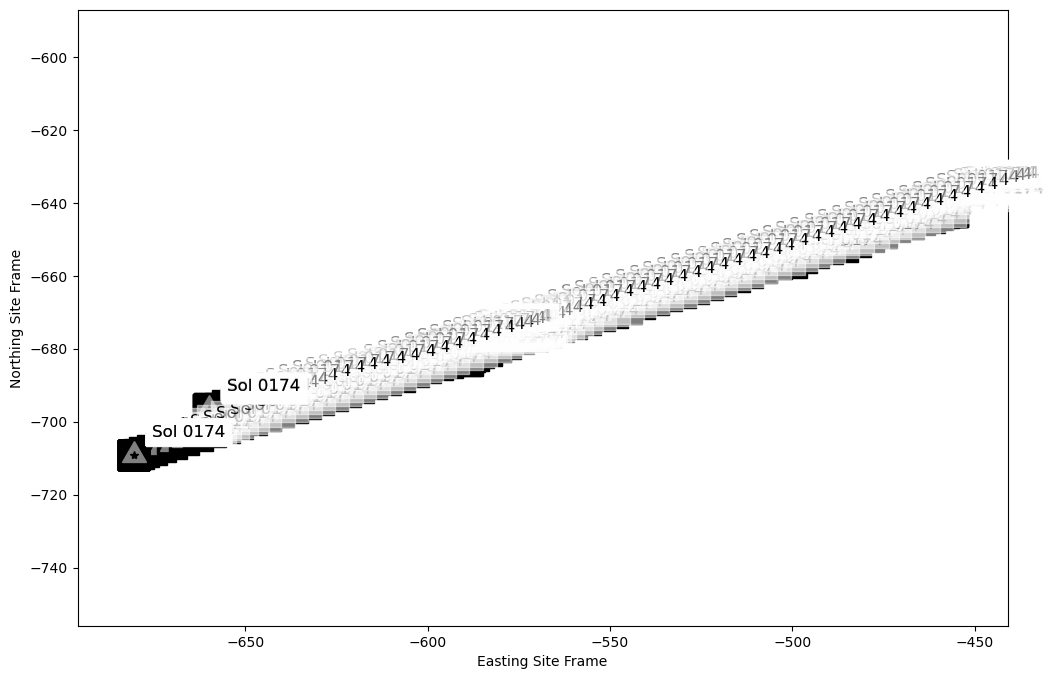

In [7]:
%%time

# time.sleep(1000)

%run MPPP.py

# image_list_process( IMG_paths[::-1], directory_output, suf, find_offsets_mode = 1 )
# image_list_process( IMG_paths[:], directory_output, suf, find_offsets_mode = 0, frame='rnav' )
image_list_process( IMG_paths[:], directory_output, suf, find_offsets_mode = 0, frame='site3' )

In [30]:
%run MPPP.py

# im = image( 'C:/Users/cdt59/Desktop/heli/data//HSF_0174_0682390593_685RAD_N0120001HELI00005_000085J02.IMG' ) # (70,40,2)
# im = image( 'C:/Users/cdt59/Desktop/heli/data//00174//ids//rdr//heli//HNM_0174_0682390574_405RAD_N0120001HELI02729_0000LUJ02.IMG', ) # (140,0,0)
im = image( 'C:/Users/cdt59/Desktop/agisoft/data\\00784\\ids\\rdr\\ncam\\NLF_0784_0736548853_487RAD_N0390926NCAM03784_0A0195J01.IMG' )
im = image( 'C:/Users/cdt59/Desktop/agisoft/data\\00784\\ids\\rdr\\ncam\\NRF_0784_0736548853_487RAD_N0390926NCAM03784_0A0195J01.IMG' )
# im = image( 'C:/Users/cdt59/Desktop/agisoft/data/zcam\\ZL0_0786_0736703534_098RAD_N0390926ZCAM08811_1100LMA01.IMG' ) 
im = image( 'C:/Users/cdt59/Desktop/agisoft/data/zcam\\ZL0_0792_0737263387_769RAD_N0390926ZCAM01023_034050A01.IMG' ) 
im = image( 'C:/Users/cdt59/Desktop/agisoft/data/zcam\\ZR0_0792_0737263387_769RAD_N0390926ZCAM01023_034050A01.IMG' ) 

im = image( IMG_paths[0] )

im.image_reference()


im.f, im.b1, im.b2, '', im.cxp, im.cyp, '', im.k1, im.k2, im.theta_degrees, im.filename

C_HELI_M [ 0.    0.06  0.14] C_HELI_takeoff [ -6.96411480e+02  -6.60136030e+02  -9.80000000e-02]


(275.50336626574546,
 -0.14341427097264159,
 1.6860934191188369e-14,
 '',
 7.2050353729077301,
 9.6560820635000084,
 '',
 0.0010660000000000001,
 -0.00039800000000000002,
 -90.0,
 'HNM_0240_0688259312_813RAD_N0130001HELI00053_0000LUJ01.IMG')

In [90]:
(im.label['RSM_ARTICULATION_STATE']['ARTICULATION_DEVICE_ANGLE'][0])

Quantity(value=3.15473, units='rad')

In [35]:
int(im.filename[9:19])

688259312

In [33]:

cmod_xml = "<?xml version=\"1.0\" encoding=\"UTF-8\"?><calibration>\n  <projection>{}</projection>\n  <width>{}</width>\n  <height>{}</height>\n  <f>{:0.6f}</f>\n  <cx>{:0.6f}</cx>\n  <cy>{:0.6f}</cy>\n  <k1>{:0.6f}</k1>\n  <k2>{:0.6f}</k2>\n  <p1>{:0.6f}</p1>\n  <p2>{:0.6f}</p2>\n  <k3>{:0.6f}</k3>\n  <k4>{:0.6f}</k4>\n  <b1>{:0.6f}</b1>\n  <b2>{:0.6f}</b2>\n</calibration>"\
            .format( im.projection, im.w, im.h, im.f, im.cxp, im.cyp, im.k1, im.k2, im.p1, im.p2, im.k3, im.k4, im.b1, im.b2 )

print(cmod_xml)

cmod_save_path = 'C:/Users/cdt59/Documents/MPPP_workspace/cmods/M2020_ZR0_034mm.xml'
with open(cmod_save_path, "w") as text_file:
    text_file.write( cmod_xml )

<?xml version="1.0" encoding="UTF-8"?><calibration>
  <projection>frame</projection>
  <width>2560</width>
  <height>960</height>
  <f>1475.234610</f>
  <cx>9.092042</cx>
  <cy>494.029161</cy>
  <k1>0.051719</k1>
  <k2>-0.018715</k2>
  <p1>0.000000</p1>
  <p2>0.000000</p2>
  <k3>0.000000</k3>
  <k4>0.000000</k4>
  <b1>0.338698</b1>
  <b2>0.142715</b2>
</calibration>


In [84]:
N = 3
D_min = 1.8
[ D_min*N/(N-n) for n in range(1,N)]

[2.7, 5.4]

In [174]:
w,h = [640,480]

# fisheye
im = image( 'C:/Users/cdt59/Desktop/heli/data//00174//ids//rdr//heli//HNM_0174_0682390574_405RAD_N0120001HELI02729_0000LUJ02.IMG', ) # (140,0,0)
Xp,Yp,Zp,yp,pp,rp = [-482.863524,-649.370648,10.150207,162.253878,-5.142142,-9.563955]

# im = image( 'C:/Users/cdt59/Desktop/heli/data//00174//ids//rdr//heli//HNM_0174_0682390575_302RAD_N0120001HELI02756_0000LUJ02.IMG', ) # (140,0,0)
# Xp,Yp,Zp,yp,pp,rp = [-479.242935,-648.062762,10.033978,161.940305,-9.974779,-10.268652] 

f, cxp, cyp, k1, k2, b1, b2 = [275.5,2.2541485333336087,11.026877077021922,-0.0086719433263928569,0.0031444070599917777,0,0]


In [176]:
im.image_reference()

ypr = np.array([yp,pp,rp])
R_site2cam = find_R_from_ypr( ypr )
# R_cam2ned  = R.from_matrix( [[0,-1,0],[1,0,0],[0,0,1]] )

R_cam2site = R_cam2ned.inv() * R_site2cam #R_veh2cam * R_veh2site.inv()

C = [ Yp, Xp, -Zp ]

cx = cxp+w/2
cy = cyp+h/2

K_cam = np.array([
            [ f+b1, b2, cx ],
            [    0,  f, cy ],
            [    0,  0,b 1 ], ])

HVA = np.matmul( K_cam, R_cam2site.as_matrix() )
H = HVA[0,:]
V = HVA[1,:]
A = HVA[2,:]
O = A
Ra = np.array([0,k1,k2])
E = np.array([0.0,0.0,0.0])

hp = ( H - cx* A ) / f
vp = ( V - cy* A ) / f

GEOMETRIC_CAMERA_MODEL = im.label['GEOMETRIC_CAMERA_MODEL']
GEOMETRIC_CAMERA_MODEL['REFERENCE_COORD_SYSTEM_NAME']  = 'SITE_FRAME'
GEOMETRIC_CAMERA_MODEL['REFERENCE_COORD_SYSTEM_INDEX'] = '3'

GEOMETRIC_CAMERA_MODEL['MODEL_COMPONENT_1'] = list( C )
GEOMETRIC_CAMERA_MODEL['MODEL_COMPONENT_2'] = list( A )
GEOMETRIC_CAMERA_MODEL['MODEL_COMPONENT_3'] = list( H )
GEOMETRIC_CAMERA_MODEL['MODEL_COMPONENT_4'] = list( V )
GEOMETRIC_CAMERA_MODEL['MODEL_COMPONENT_5'] = list( O )
GEOMETRIC_CAMERA_MODEL['MODEL_COMPONENT_6'] = list( Ra )
GEOMETRIC_CAMERA_MODEL['MODEL_COMPONENT_Y'] = list( E )

print( im.filename)

text = [im.filename, C[0], C[1], C[2], A[0], A[1], A[2],  H[0], H[1], H[2], V[0], V[1], V[2], O[0], O[1], O[2], Ra[0], Ra[1], Ra[2], E[0], E[1], E[2], ]

np.savetxt( im.filename[:-4]+'.cmod', text[:], delimiter=',', fmt='%s ' )

HNM_0174_0682390574_405RAD_N0120001HELI02729_0000LUJ02.IMG


In [16]:
# For find_offset_mode = 1

# # pos_lines  = []
# # rover_xyzs = []
# # im_xyzs    = []
# # sols       = []
# # rmcs = []
sites  = [ rmcs[i][0] for i in range(len(rmcs))[::-1] ]
drives = [ rmcs[i][1] for i in range(len(rmcs))[::-1] ]
Xs     = [ rover_xyzs[i][0] for i in range(len(rover_xyzs))[::-1] ]
Ys     = [ rover_xyzs[i][1] for i in range(len(rover_xyzs))[::-1] ]
Zs     = [ rover_xyzs[i][2] for i in range(len(rover_xyzs))[::-1] ]

table = np.stack( [sols[::-1], sites, drives, Xs, Ys, Zs], axis=1)
np.round( table, 4 )

np.savetxt( directory_output+"/offsets.csv", table, delimiter="\t")

NameError: name 'rmcs' is not defined

In [186]:
q_T_aim = R.from_euler( 'zyx', (70,38,4),degrees=True )

q_cam2enu = q_T_aim.inv() *q_cam * im.q_G * im.q_M *q_ned2enu

q_cam2enu.as_rotvec(degrees=1)

array([ -13.95403568, -122.26286237,   67.64833285])

In [4]:
import urllib.request, json 

'''

https://mars.nasa.gov/mmgis-maps/M20/Layers/json/M20_waypoints.json

https://docs.google.com/spreadsheets/d/1GSNJL-e5iROCaKUC4BXL_OA8hWy8vUdfCN7levRNkZA/edit#gid=1232397498

''' 
# path =  'C:/Users/cornell/Downloads/M20_waypoints.json'
# with open( path ) as f:
#     data = json.load(f)

with urllib.request.urlopen("https://mars.nasa.gov/mmgis-maps/M20/Layers/json/M20_waypoints.json") as url:
    data = json.loads(url.read().decode())

    
site3_E = data['features'][0]['properties']['easting']
site3_N = data['features'][0]['properties']['northing']
site3_A = data['features'][0]['properties']['elev_geoid']


for i in range(len(data['features']))[::-1]:
    
    print( data['features'][i]['properties']['sol'],'\t',
           data['features'][i]['properties']['site'], '\t',
           data['features'][i]['properties']['drive'],'\t',
           '0.0'+'\t','0.0'+'\t','0.0'+'\t',
           np.round( np.float64(data['features'][i]['properties']['easting'])- np.float64(site3_E), 3),'\t',
           np.round( np.float64(data['features'][i]['properties']['northing'])- np.float64(site3_N), 3),'\t',
           np.round( np.float64(data['features'][i]['properties']['elev_geoid'])- np.float64(site3_A), 3),'\t',
         )

856 	 42 	 0 	 0.0	 0.0	 0.0	 -4845.247 	 2161.263 	 154.214 	
856 	 41 	 672 	 0.0	 0.0	 0.0	 -4841.025 	 2163.94 	 154.016 	
854 	 41 	 562 	 0.0	 0.0	 0.0	 -4831.977 	 2164.844 	 154.005 	
848 	 41 	 188 	 0.0	 0.0	 0.0	 -4781.195 	 2180.602 	 154.716 	
848 	 41 	 80 	 0.0	 0.0	 0.0	 -4786.586 	 2178.378 	 154.412 	
843 	 41 	 0 	 0.0	 0.0	 0.0	 -4782.156 	 2182.185 	 154.706 	
843 	 40 	 1706 	 0.0	 0.0	 0.0	 -4787.905 	 2181.431 	 154.447 	
838 	 40 	 1608 	 0.0	 0.0	 0.0	 -4783.193 	 2171.856 	 154.351 	
836 	 40 	 992 	 0.0	 0.0	 0.0	 -4733.315 	 2245.44 	 153.561 	
821 	 40 	 132 	 0.0	 0.0	 0.0	 -4649.131 	 2273.826 	 149.121 	
821 	 40 	 70 	 0.0	 0.0	 0.0	 -4644.041 	 2275.221 	 148.731 	
818 	 40 	 0 	 0.0	 0.0	 0.0	 -4649.281 	 2276.728 	 148.901 	
818 	 39 	 1550 	 0.0	 0.0	 0.0	 -4648.226 	 2283.74 	 148.704 	
816 	 39 	 1418 	 0.0	 0.0	 0.0	 -4629.225 	 2300.703 	 147.718 	
816 	 39 	 1294 	 0.0	 0.0	 0.0	 -4625.095 	 2277.624 	 147.133 	
797 	 39 	 1170 	 0.0	 0.0	 0.0

In [29]:
data['features'][-1]

{'type': 'Feature',
 'properties': {'RMC': '40_132',
  'site': 40,
  'drive': 132,
  'sol': 821,
  'easting': 4349844.955,
  'northing': 1095573.521,
  'elev_geoid': -2420.788818,
  'elev_radii': -4108.919434,
  'radius': 3392081.08,
  'lon': 77.36819431,
  'lat': 18.48298797,
  'roll': 8.657,
  'pitch': 4.009,
  'yaw': -106.695,
  'yaw_rad': -1.8622,
  'tilt': 9.534,
  'dist_m': 10.97,
  'dist_total_m': 18718.678,
  'dist_km': 18.72,
  'dist_mi': 11.63,
  'final': 'y',
  'Note': 'Used Mobility Report WID 48211',
  'images': [{'name': 'Panorama',
    'isPanoramic': True,
    'url': 'Layers/mosaics/N_LRGB_0821_RZS_0400132_CYL_L_AUTOGENJ01.jpg',
    'rows': '2247',
    'columns': '9292',
    'azmin': '0',
    'azmax': '360',
    'elmin': '-69.3863',
    'elmax': '17.6854',
    'elzero': '457.492'}]},
 'geometry': {'type': 'Point',
  'coordinates': [77.36819431, 18.48298797, -2420.788818]}}

In [ ]:

HNM_0174_0682390670_246RAD_N0120001HELI05618_0000LUJ02.png	-659.99704	-696.61814	0.00427	-5.22666	-0.51619	-161.39815	0	0	-1
HNM_0193_0684072284_736RAD_N0130001HELI00496_0000LUJ02.png	-654.60816	-707.83441	-0.34953	0.64222	8.10263	-152.55907